# Feature Set Collections

In [1]:
import init
import common.constants as cn
import common_python.constants as ccn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import feature_analyzer
from common_python.classifier import feature_set_collection
from common_python.util import util
from common import transform_data
from common_python.classifier.feature_set import FeatureSet
from common import trinary_data

import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from sklearn import svm

%matplotlib inline

In [2]:
# These are the "long" data that have individual replications, not averages. And, only using TFs.
PROVIDER = DataProvider()
PROVIDER.do()
TRINARY = TrinaryData(is_averaged=False, is_dropT1=False, is_regulator=True)  # Trinary data
DF_X = TRINARY.df_X
SER_Y = TRINARY.ser_y
STATES = SER_Y.unique()
REGULATORS = DF_X.columns.tolist()
DATA_PATH = cn.PROJECT_DIR
for directory in ["data", "feature_analyzer"]:
    DATA_PATH = os.path.join(DATA_PATH, directory)
DATA_PATH_PAT = os.path.join(DATA_PATH, "%d") 
ANALYZER_DCT = feature_analyzer.deserialize({s: DATA_PATH_PAT % s for s in STATES})
ANALYZERS = ANALYZER_DCT.values()
COLLECTION_DCT = {s: feature_set_collection.FeatureSetCollection.deserialize(DATA_PATH_PAT % s) for s in STATES}
_ = [c.ser_comb for c in COLLECTION_DCT.values()]

In [3]:
PROVIDER.df_go_terms.head()

,GENE_ID,GO_Term
0,P9WKY5,host cell nucleus
1,Rv0001,DNA replication initiation---dephosphorylation...
2,Rv0002,extracellular region---cell wall
3,Rv0003,double-strand break repair---cytosol---plasma ...
4,Rv0005,DNA topological change---growth---magnesium io...


In [4]:
SAMPLE_DATA = trinary_data.getSampleData()
DF_AM = SAMPLE_DATA.AM_MDM
DF_AW = SAMPLE_DATA.AW
DF_GALAGAN = SAMPLE_DATA.galagan

# Alternative Feature Sets

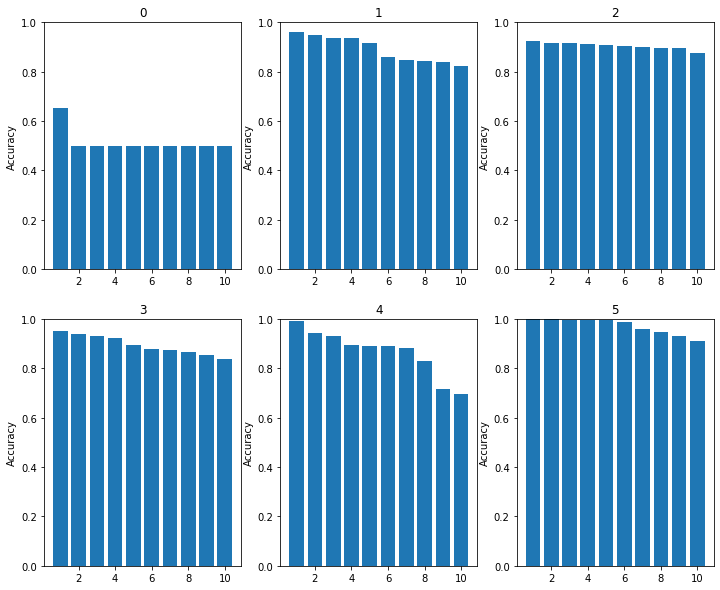

In [5]:
nrow = 2
ncol = 3
xv = range(1, 11)
fig, axes = plt.subplots(nrow, ncol, figsize=(12, 10))
for state in STATES:
    row = int(state/ncol)
    col = state % ncol
    collection = COLLECTION_DCT[state]
    ax = axes[row, col]
    values = collection.ser_comb.to_list()
    ax.bar(xv, values[:len(xv)])
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.set_title("%d" % state)
    
    

In [6]:
COLLECTION_DCT[1].ser_comb.head()

Rv3095+Rv3246c                            0.958333
Rv2009+Rv3830c                            0.950000
Rv0054+Rv3066+Rv3133c                     0.936667
Rv0158+Rv0653c+Rv1176c+Rv2745c+Rv3082c    0.935000
Rv1460                                    0.915000
Name: 0, dtype: float64

In [7]:
fset = FeatureSet("Rv3095+Rv3246c", analyzer=COLLECTION_DCT[1]._analyzer)
df = fset.profileTrinary()
del df["feature_set"]
df

,predicted,count,frac,siglvl_pos,siglvl_neg
value,,,,,
"(-1, -1)",0,2.0,0.00,1.000000,0.000000
"(-1, 0)",0,22.0,0.00,1.000000,0.000000
"(-1, 1)",0,11.0,0.00,1.000000,0.000000
"(0, -1)",0,0.0,NaN,NaN,NaN
"(0, 0)",0,20.0,0.05,0.999999,0.000020
"(0, 1)",1,20.0,0.85,0.001288,0.999799
"(1, -1)",0,0.0,NaN,NaN,NaN
"(1, 0)",1,0.0,NaN,NaN,NaN
"(1, 1)",1,0.0,NaN,NaN,NaN


## Profile Instances

In [8]:
def plotProfile(state, count=3):
    collection = COLLECTION_DCT[state]
    collection.plotProfileInstance(collection.ser_comb.index.tolist()[0:count], figsize=(16, 10))

In [ ]:
for state in STATES:
    plotProfile(state)

## Instance Evaluation

In [ ]:
 def fullProfile(ser_X, title="", **kwargs):
        num_row = 2 
        num_col = 3 
        fig, axes = plt.subplots(num_row, num_col,
            figsize=(16, 10))
        for idx, state in enumerate(STATES):
            row = int(idx/num_col)
            col = idx % num_col
            collection = COLLECTION_DCT[state]
            if row == 0:
                label_xoffset = -0.1
            else:
                label_xoffset = 0.1 
            collection.plotEvaluate(ser_X, 
                ax=axes[row, col], is_plot=False,
                title = "State %d" % idx,
                label_xoffset=label_xoffset, **kwargs)
        fig.suptitle(title, fontsize=16)
        plt.show()

In [ ]:
instance = "T3.0"
ser_X = DF_X.loc[instance]
fullProfile(ser_X, title=instance)

In [ ]:
DF_AW.head()

In [ ]:
for instance in DF_AM.index:
    ser_X = DF_AM.loc[instance]
    fullProfile(ser_X, title=instance)

In [ ]:
for instance in DF_AW.index:
    ser_X = DF_AW.loc[instance]
    fullProfile(ser_X, title=instance, num_fset=5)

In [ ]:
sorted_index = sorted(DF_GALAGAN.index.tolist(), key=lambda v: float(int(v[1]) + 0.1*int(v[6])))
for instance in sorted_index:
    ser_X = DF_GALAGAN.loc[instance]
    fullProfile(ser_X, title=instance, num_fset=15)

## Gene Analysis

In [ ]:
def reportGO(genes):
    df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
    result = []
    for gene in genes:
        if gene in df.index.tolist():
            result.append('"%s: %s"\n' % (gene, df.loc[gene, "GO_Term"]))
        else:
            result.append('"%s: no description"\n' % gene)
    return result
genes = ["Rv3095", "Rv3246c", "Rv2009", "Rv3830c", "Rv0602c", "Rv1956", "Rv3249c"]
print("\n".join(reportGO(genes)))

In [ ]:
PROVIDER.df_go_terms.head()

In [ ]:
ser = pd.Series(reportGO(PROVIDER.tfs))
ser.to_csv("trn_report.csv")

In [ ]:
df = PROVIDER.df_go_terms.set_index(cn.GENE_ID)
df.loc["Rv0674", :]